In [4]:
import torch
import matplotlib.pyplot as plt
from ultralytics import YOLO
from datasets import YOLODataset
from datasets import yolo_collate_fn
from torch.utils.data import DataLoader
from collections import Counter

In [5]:
# Root directory of the dataset
class_names = ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']
num_classes = len(class_names)
root_dir = 'datasets/aquarium-data-cots/aquarium_pretrain'

# Create datasets
train_dataset = YOLODataset(root_dir, split='train', num_classes=num_classes)
valid_dataset = YOLODataset(root_dir, split='valid', num_classes=num_classes)
test_dataset = YOLODataset(root_dir, split='test', num_classes=num_classes)

# Custom sampler for balanced class representation
train_sampler = train_dataset.get_sampler()  

# Create data loaders with the custom collate function to track class counts
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(valid_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Training samples: 448
Validation samples: 127
Test samples: 63


## Visualization

In [6]:
def visualize_augmented_images(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
    
    for i in range(num_samples):
        image, labels, bboxes = dataset[i]
        
        image = image.permute(1, 2, 0).numpy()  # Change from CxHxW to HxWxC, tensor to numpy for plotting
        
        ax = axes[i]
        ax.imshow(image)
        
        # Draw bounding boxes
        for bbox in bboxes:
            xmin, ymin, xmax, ymax, class_id = bbox
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                      edgecolor='red', facecolor='none', linewidth=2))
            ax.text(xmin, ymin, f'Class {int(class_id)}', color='white', fontsize=10, 
                    bbox=dict(facecolor='red', alpha=0.5))
        
        ax.axis('off') 
    
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6225708].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3262744].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


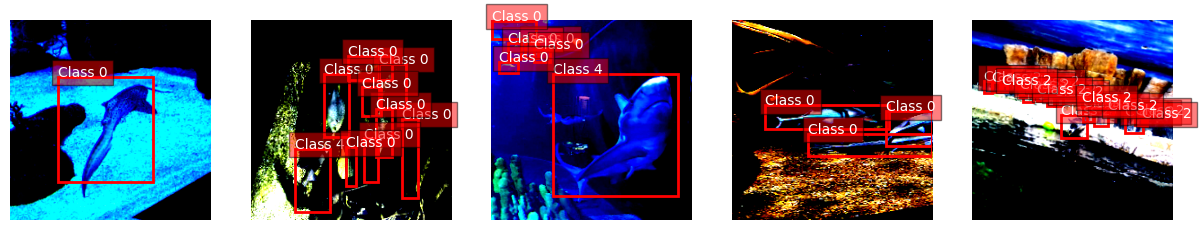

In [7]:
visualize_augmented_images(train_dataset, num_samples=5)

## Model

In [8]:
# Define the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = YOLO('yolov5su.pt')
model = model.to(device)

## Train

In [9]:
num_epochs = 25

model.train(
    data='datasets/aquarium-data-cots/aquarium_pretrain/data.yaml', 
    epochs=num_epochs, 
    imgsz=640,  
    save_period=1,  # Save model every epoch
    # hyp='datasets/aquarium-data-cots/aquarium_pretrain/hyp.yaml', # Hyperparameter file
    save_dir='runs/train',  # Directory to save training results
)

New https://pypi.org/project/ultralytics/8.3.38 available 😃 Update with 'pip install -U ultralytics'
engine/trainer: task=detect, mode=train, model=yolov5su.pt, data=datasets/aquarium-data-cots/aquarium_pretrain/data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=cuda:0, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=

train: Scanning /home/ubuntu/cs230_hannah/cs230_project/datasets/aquarium-data-cots/aquarium_pretrain/train/labels.cache... 448 images, 1 backgrounds, 0 corrupt: 100%|██████████| 448/448 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /home/ubuntu/cs230_hannah/cs230_project/datasets/aquarium-data-cots/aquarium_pretrain/valid/labels.cache... 127 images, 0 backgrounds, 0 corrupt: 100%|██████████| 127/127 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train5
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.98G      1.568      2.942      1.336        132        640: 100%|██████████| 28/28 [00:04<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.89it/s]

                   all        127        909      0.356      0.416      0.313      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      4.03G      1.534      1.918      1.253        191        640: 100%|██████████| 28/28 [00:04<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.26it/s]

                   all        127        909      0.492      0.465      0.427      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      4.01G      1.511      1.674      1.237        190        640: 100%|██████████| 28/28 [00:04<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.36it/s]

                   all        127        909      0.436      0.454      0.391      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      3.95G       1.49      1.521      1.246        216        640: 100%|██████████| 28/28 [00:04<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.66it/s]

                   all        127        909      0.502      0.541      0.527      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      3.91G      1.476       1.43      1.226        318        640: 100%|██████████| 28/28 [00:04<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.50it/s]

                   all        127        909      0.609      0.482      0.538      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      3.98G       1.47      1.362      1.223        191        640: 100%|██████████| 28/28 [00:04<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.52it/s]

                   all        127        909      0.663      0.489      0.514      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      4.01G      1.428      1.313      1.214        202        640: 100%|██████████| 28/28 [00:04<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.59it/s]

                   all        127        909      0.584       0.52      0.547      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      4.05G      1.425      1.258      1.214        146        640: 100%|██████████| 28/28 [00:04<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.84it/s]

                   all        127        909      0.646      0.536      0.603      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      4.06G       1.37      1.171      1.181        185        640: 100%|██████████| 28/28 [00:04<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.66it/s]

                   all        127        909      0.661       0.59      0.623      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      3.91G      1.343      1.146      1.172        167        640: 100%|██████████| 28/28 [00:04<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.75it/s]

                   all        127        909      0.748      0.581       0.64      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      3.91G      1.347      1.149      1.178        302        640: 100%|██████████| 28/28 [00:04<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.69it/s]

                   all        127        909      0.643      0.623      0.641      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      3.89G      1.345      1.098      1.176        197        640: 100%|██████████| 28/28 [00:04<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.73it/s]

                   all        127        909      0.682       0.68      0.702      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      4.57G      1.321      1.108       1.15        245        640: 100%|██████████| 28/28 [00:04<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.79it/s]

                   all        127        909      0.711      0.669      0.715      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      3.97G       1.31      1.091      1.154        210        640: 100%|██████████| 28/28 [00:04<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.72it/s]

                   all        127        909       0.76      0.669      0.714      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      4.02G      1.292     0.9921      1.125        155        640: 100%|██████████| 28/28 [00:04<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.82it/s]

                   all        127        909      0.716      0.668      0.715      0.413


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25       3.9G      1.286      1.034      1.124        143        640: 100%|██████████| 28/28 [00:04<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.63it/s]

                   all        127        909      0.739       0.66      0.721      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      3.92G      1.239     0.9389      1.118        101        640: 100%|██████████| 28/28 [00:04<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.77it/s]

                   all        127        909      0.729       0.69      0.731      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25       3.9G      1.202       0.88      1.101        121        640: 100%|██████████| 28/28 [00:04<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.78it/s]

                   all        127        909       0.76      0.705       0.75      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25       3.9G      1.193     0.8485      1.078         89        640: 100%|██████████| 28/28 [00:04<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.79it/s]

                   all        127        909      0.759      0.706      0.749      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      3.85G      1.164      0.808      1.069        116        640: 100%|██████████| 28/28 [00:04<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.79it/s]

                   all        127        909      0.722      0.682      0.734      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      3.92G      1.177     0.8055      1.079        144        640: 100%|██████████| 28/28 [00:04<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.77it/s]

                   all        127        909       0.83      0.678      0.763      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      3.91G       1.14     0.7597      1.051        100        640: 100%|██████████| 28/28 [00:04<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.90it/s]

                   all        127        909      0.777      0.717      0.764      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25       3.9G      1.131     0.7433      1.043         89        640: 100%|██████████| 28/28 [00:04<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.88it/s]

                   all        127        909      0.827      0.696      0.779      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      3.87G      1.096     0.7117      1.041         86        640: 100%|██████████| 28/28 [00:04<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.73it/s]

                   all        127        909      0.797      0.736      0.783      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      3.87G      1.084     0.7001      1.031         89        640: 100%|██████████| 28/28 [00:04<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.81it/s]

                   all        127        909      0.792      0.734       0.78      0.486



25 epochs completed in 0.039 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 18.5MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 18.5MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.15 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22478MiB)
YOLOv5s summary (fused): 193 layers, 9,114,245 parameters, 0 gradients, 23.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


                   all        127        909      0.792      0.737      0.783      0.488
                  fish         63        459      0.848      0.769      0.833       0.49
             jellyfish          9        155      0.872       0.91      0.952      0.562
               penguin         17        104      0.746      0.808      0.773      0.369
                puffin         15         74      0.619      0.526      0.576      0.286
                 shark         28         57      0.865      0.684      0.772      0.516
              starfish         17         27      0.924      0.704      0.789       0.61
              stingray         23         33      0.672      0.758      0.789      0.582
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train5


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x776812086710>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

## Validation Set

In [ ]:
data_yaml_path = 'datasets/aquarium-data-cots/aquarium_pretrain/data.yaml'

# Run validation (inference) on the validation set
results = model.val(
    data=data_yaml_path,  # Path to the data.yaml file
    conf=0.5,              # Confidence threshold for predictions
    save_json=True,        # Optionally save results in COCO JSON format
    save_txt=True,         # Optionally save predictions as YOLO-format .txt files
)